In [58]:
import warnings
warnings.filterwarnings('ignore')

### First, we'll import our scores data. We can check the average score data and count.

In [59]:
import pandas as pd

scores_df = pd.read_csv("scores.csv")
scores_df.head()

,device,videoA,videoB,score
0,iPad Pro 2 12.9,273,278,0
1,iPad Pro 2 12.9,213,209,-1
2,iPad Pro 2 12.9,317,314,0
3,iPhone X,209,201,0
4,iPad Pro 2 12.9,102,98,-2


In [60]:
scores = pd.DataFrame(scores_df.groupby(['videoA','videoB'])['score'].mean())
scores['rating_count'] = scores_df.groupby(['videoA','videoB'])['score'].count()
scores.describe()

,score,rating_count
count,331.000000,331.000000
mean,-0.048137,1.679758
std,1.397550,1.053212
min,-2.000000,1.000000
25%,-1.000000,1.000000
50%,0.000000,1.000000
75%,1.000000,2.000000
max,2.000000,6.000000


### As we can see, theres only a maximum of 6 ratings per video comparison. Because we don't care about the individual video itself, but the quality of that video, let's use the video quality details to increase the amount of ratings per pair.

#### First, let's prepare the videos dataframe. We will treat all features as categorical. 

In [61]:
videos_df = pd.read_csv("videos.csv")
videos_df["output_resolution"] = videos_df["output_height"].map(str) + " x " + videos_df["output_width"].map(str)
videos_df["bitrate"] = videos_df["bitrate"].map(str)
videos_df["frame_rate"] = videos_df["frame_rate"].map(str)
videos_df = videos_df.drop(videos_df.columns[[4,7,8,9,10]], axis=1) 

categorical_cols = ['bitrate', 'codec', 'color_space', 'eotf', 'frame_rate', 'output_resolution']
videos_df_cat = videos_df[categorical_cols]
videos_df_cat = pd.get_dummies(videos_df_cat, prefix=['bitrate', 'codec', 'color_space', 'eotf', 'frame_rate', 'output_resolution'])
videos_df = pd.concat([videos_df["id"],videos_df_cat], axis=1)

videos_df_a = videos_df.add_prefix("videoA_")
videos_df_b = videos_df.add_prefix("videoB_")

df = scores_df.merge(videos_df_a, how='left', left_on='videoA', right_on='videoA_id')
df = df.merge(videos_df_b, how='left', left_on='videoB', right_on='videoB_id')
df = df.drop(df.columns[[1,2,4,26]], axis=1)

#put score as last column
scores = df['score']
df.drop('score', axis=1, inplace=True)
df['score'] = scores
df.head()

,device,videoA_bitrate_1300,videoA_bitrate_2000,videoA_bitrate_2200,videoA_bitrate_3000,videoA_bitrate_3500,videoA_bitrate_4500,videoA_bitrate_5300,videoA_bitrate_7000,videoA_bitrate_8000,...,videoB_color_space_bt.709,videoB_eotf_SDR,videoB_frame_rate_24,videoB_frame_rate_29,videoB_frame_rate_60,videoB_output_resolution_1080 x 1920,videoB_output_resolution_360 x 640,videoB_output_resolution_540 x 960,videoB_output_resolution_720 x 1280,score
0,iPad Pro 2 12.9,1,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,1,0
1,iPad Pro 2 12.9,0,0,0,0,0,0,1,0,0,...,1,1,0,0,1,1,0,0,0,-1
2,iPad Pro 2 12.9,0,0,0,0,0,0,1,0,0,...,1,1,0,0,1,0,0,0,1,0
3,iPhone X,0,0,0,0,0,0,0,0,1,...,1,1,0,1,0,0,0,0,1,0
4,iPad Pro 2 12.9,0,0,0,0,1,0,0,0,0,...,1,1,0,0,1,0,0,0,1,-2


### We will create a dataframe for each device and use it to create a linear regression. The goal of this is to determine the most important feature that determines the ratings.

In [62]:
devices = {}
for device in df['device']:
    devices[device] = []
print(devices)

{'samsung SM-G960U': [], 'samsung SM-G975U1': [], 'simulator/sandbox': [], 'iPad Air': [], 'unknown sdk_google_atv_x86': [], 'iPhone 7': [], 'Google Pixel 3a': [], 'iPhone X': [], 'iPad Pro 2 12.9': [], 'iPad Pro 10.5': []}


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

features = df.columns[1:(len(df.columns)-2)]
most_important_features = {}

for device in devices:
    d = []
    for index, row in df.iterrows():
        if row['device'] == device:
            d.append(row)
    d_df = pd.DataFrame(d)
    
    if len(d_df) > 3:
        X = d_df[features]
        y = d_df['score']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=5)
        linreg = LinearRegression()
        linreg.fit(X_train, y_train)

        most_important = 0
        for i in range(len(linreg.coef_)):
            if max(linreg.coef_[most_important], linreg.coef_[i], key=abs) == linreg.coef_[i]:
                most_important = i

        most_important_features[device] = features[most_important]
df_most_important_features = pd.DataFrame(list(most_important_features.items()))
df_most_important_features

,0,1
0,simulator/sandbox,videoB_bitrate_3500
1,iPad Air,videoA_output_resolution_540 x 960
2,unknown sdk_google_atv_x86,videoB_output_resolution_540 x 960
3,Google Pixel 3a,videoB_output_resolution_1080 x 1920
4,iPhone 7,videoA_bitrate_1300
5,iPad Pro 2 12.9,videoA_bitrate_850
6,iPad Pro 10.5,videoA_output_resolution_720 x 1280


#### Here, we can conclude that for different devices, different features were most import

#### Next, we will get the average scores and scores counts. Here we can see that while we have about the max rating count is 33 rather than just 6.

In [64]:
avg_score_cols = list(df)[:-1]
avg_scores = pd.DataFrame(df.groupby(avg_score_cols)['score'].mean())
avg_scores['rating_count'] = df.groupby(avg_score_cols)['score'].count()
avg_scores.head()

score  \
device          videoA_bitrate_1300 videoA_bitrate_2000 videoA_bitrate_2200 videoA_bitrate_3000 videoA_bitrate_3500 videoA_bitrate_4500 videoA_bitrate_5300 videoA_bitrate_7000 videoA_bitrate_8000 videoA_bitrate_850 videoA_codec_AVC videoA_codec_HEVC videoA_color_space_bt.709 videoA_eotf_SDR videoA_frame_rate_24 videoA_frame_rate_29 videoA_frame_rate_60 videoA_output_resolution_1080 x 1920 videoA_output_resolution_360 x 640 videoA_output_resolution_540 x 960 videoA_output_resolution_720 x 1280 videoB_bitrate_1300 videoB_bitrate_2000 videoB_bitrate_2200 videoB_bitrate_3000 videoB_bitrate_3500 videoB_bitrate_4500 videoB_bitrate_5300 videoB_bitrate_7000 videoB_bitrate_8000 videoB_bitrate_850 videoB_codec_AVC videoB_codec_HEVC videoB_color_space_bt.709 videoB_eotf_SDR videoB_frame_rate_24 videoB_frame_rate_29 videoB_frame_rate_60 videoB_output_resolution_1080 x 1920 videoB_output_resolution_360 x 640 videoB_output_resolution_540 x 960 videoB_output_resolution_720 x 1280          
Google Pixel 3a 0                   0                   0                   0                   0                   0                   0                   0                   1                   0                  0                1                 1                         1               0                    0                    1                    1                                    0                                  0                                  0                                   1                   0                   0                   0                   0                   0                   0                   0                   0                   0                  0                1                 1                         1               0                    0                    1                    0                                    0                                  0                                  1                                     -2.0   
                                                                                                                                        1                   0                   0                   0                  0                1                 1                         1               0                    0                    1                    0                                    0                                  0                                  1                                   0                   0                   0                   0                   0                   0                   0                   0                   0                   1                  0                1                 1                         1               0                    1                    0                    0                                    1                                  0                                  0                                     -2.0   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  1                   0                   0                   0                   0                   0                  0                1                 1                         1               0                    0                    1                    1                                    0                                  0                                  0                                     -0.5   
                               


#### Building a Histogram to vizualize the ratings

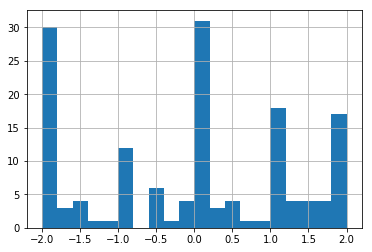

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
avg_scores['score'].hist(bins=20)


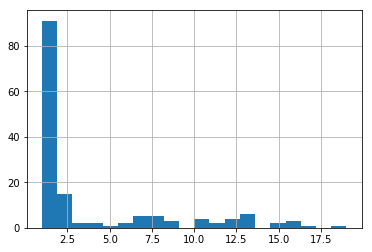

In [66]:
avg_scores['rating_count'].hist(bins=20)


#### Using the jointplot() function to to check the relationship between average score and score count.

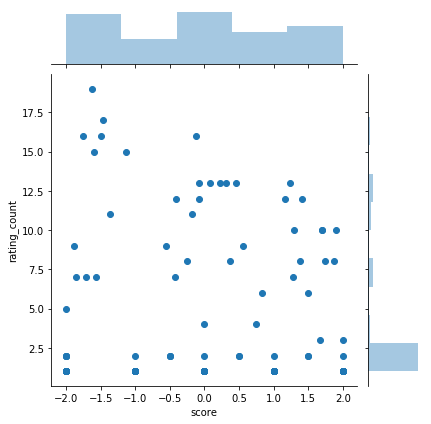

In [67]:
import seaborn as sns
sns.jointplot (x='score', y='rating_count', data=avg_scores)